In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit
import glob

from qiskit.opflow.evolutions import PauliTrotterEvolution
from qiskit.opflow import PauliOp
from qiskit.opflow import PauliSumOp
from qiskit.providers import aer
from qiskit.quantum_info import Pauli

import dqs

In [2]:
pte = PauliTrotterEvolution(trotter_mode='trotter', reps=1)

In [3]:
pauli = Pauli('Y')
pauli_op = PauliOp(pauli)

In [4]:
circ_op = pte.evolution_for_pauli(pauli_op)

In [5]:
circ_op.to_circuit().draw()

┌─────┐┌───┐┌───────┐┌───┐┌───┐
q_0: ┤ Sdg ├┤ H ├┤ Rz(2) ├┤ H ├┤ S ├
     └─────┘└───┘└───────┘└───┘└───┘

In [6]:
d = dqs.quantum_dynamics.Dynamics("EXACT: (1)Y + (1)X")
circ = d.gen_circuit(1, r=2)
circ.draw()

┌─────┐┌───┐┌───────┐┌───┐┌───┐ ░ ┌───┐┌───────┐┌───┐ ░ ┌─────┐┌───┐»
q0_0: ┤ Sdg ├┤ H ├┤ Rz(1) ├┤ H ├┤ S ├─░─┤ H ├┤ Rz(1) ├┤ H ├─░─┤ Sdg ├┤ H ├»
      └─────┘└───┘└───────┘└───┘└───┘ ░ └───┘└───────┘└───┘ ░ └─────┘└───┘»
«      ┌───────┐┌───┐┌───┐ ░ ┌───┐┌───────┐┌───┐ ░ 
«q0_0: ┤ Rz(1) ├┤ H ├┤ S ├─░─┤ H ├┤ Rz(1) ├┤ H ├─░─
«      └───────┘└───┘└───┘ ░ └───┘└───────┘└───┘ ░

In [7]:
dqs_circuit_unitary = d.getCircuitUnitary()
print(dqs_circuit_unitary)

[[ 0.1862656 -0.35403672j -0.64805984-0.64805984j]
 [ 0.64805984-0.64805984j  0.1862656 +0.35403672j]]


In [154]:
pauli_table = qiskit.quantum_info.PauliTable.from_labels(['Y', 'X'])
sparse_pauli_op = qiskit.quantum_info.SparsePauliOp(pauli_table)
print(sparse_pauli_op)

SparsePauliOp([[ True,  True],
               [ True, False]],
              coeffs=[1.+0.j, 1.+0.j])


In [157]:
pauli_sum_op = PauliSumOp(sparse_pauli_op)
print(pauli_sum_op)
exact_unitary = pauli_sum_op.exp_i().to_matrix()
print(exact_unitary)
print(pauli_sum_op.to_matrix())
print(type(pauli_sum_op.to_matrix().dtype))

1.0 * Y
+ 1.0 * X
[[ 0.15594369+0.j       -0.698456  -0.698456j]
 [ 0.698456  -0.698456j  0.15594369+0.j      ]]
[[0.+0.j 1.-1.j]
 [1.+1.j 0.+0.j]]
<class 'numpy.dtype[complex128]'>


In [10]:
d.processFidelity(exact_unitary, dqs_circuit_unitary)

0.873

In [11]:
d.compute2Norm(exact_unitary, dqs_circuit_unitary)

0.3624099347864013

In [12]:
d.mathematicaFidelity(exact_unitary, dqs_circuit_unitary)

0.9343295186845595

In [5]:
def get_pauli_sum_op(H, coeff=1.0):
    #pauli_table = qiskit.quantum_info.PauliTable.from_labels([term[1] for term in H])
    #sparse_pauli_op = qiskit.quantum_info.SparsePauliOp(pauli_table, [term[0] for term in H])
    H_as_list = [(term[1], term[0]) for term in H]
    return PauliSumOp.from_list(H_as_list, coeff=coeff)

def get_exact_unitary(H):
    pauli_sum_op = get_pauli_sum_op(H)
    return pauli_sum_op.exp_i().to_matrix()

def fidelity_over_r(H, sort_type, r_vals):
    
    exactU = get_exact_unitary(H)
    
    exact_H_str = 'EXACT: ' + dqs.hamiltonians.get_H_str(H)
        
    dynamics = dqs.quantum_dynamics.Dynamics(exact_H_str)
    dynamics.sort_hamiltonian(sort_type=sort_type, print_info=False)
    
    fidelities = []
    for r in r_vals:
        dynamics.gen_circuit(t=1, r=r)
        circuitU = dynamics.getCircuitUnitary()
        fidelities.append(dynamics.processFidelity(exactU, circuitU))
    
    return fidelities


def plot(r_vals, fids, labels, H, title=None):
    fig, ax = plt.subplots(dpi=150)

    for label, fid in zip(labels, fids):
        print(f'{label}: {fid}')
        ax.plot(r_vals, fid, label=label)

    ax.grid()
    ax.set_ylabel('Process fidelity')
    ax.set_xlabel('repetitions, r')
    if title is None:
        hstr = dqs.hamiltonians.get_H_str(H, sigfigs=2)
        harray = hstr.split('+')
        if len(harray) > 5:
            hstr = harray[0]
            i = 1
            for term in harray[1:]:
                hstr += f' + {term}'
                i += 1
                if i >= 5:
                    hstr += '\n'
                    i = 0
        ax.set_title('H = ' + hstr)
    else:
        ax.set_title(title)
    ax.legend()
    plt.show()
    plt.close()

In [68]:
H = [(1, 'XZ'), (1, 'XX'), (1, 'ZX')]
r_vals = [1, 2, 4, 6, 8, 10]

lex_fidelity = fidelity_over_r(H, 'lex', r_vals)
mct_fidelity = fidelity_over_r(H, 'mc_tsp', r_vals)
mag_fidelity = fidelity_over_r(H, 'mag', r_vals)

Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.84139704e-08 -3.84139704e-08 -2.14644078e-08 -2.14644078e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.842715e-08 -2.842715e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.56178026e-08 -4.56178026e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.14644078e-08 -2.14644078e-08 -1.36128586e-08 -1.36128586e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [1.97156453e-08 1.97156453e-08 2.99990497e-08 2.99990497e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.84139704e-08 -3.84139704e-08 -2.14644078e-08 -2.14644078e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.842715e-08 -2.842715e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.56178026e-08 -4.56178026e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.14644078e-08 -

lex: [0.4633, 0.9206, 0.9835, 0.9929, 0.9961, 0.9975]
mc_tsp: [0.4633, 0.9206, 0.9835, 0.9929, 0.9961, 0.9975]
mag: [0.1513, 0.6947, 0.9148, 0.9613, 0.9781, 0.9859]


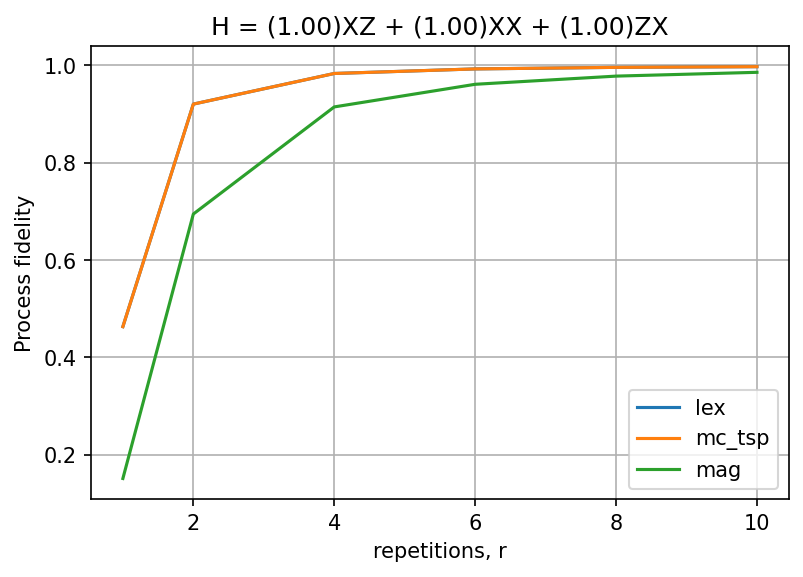

In [69]:
plot(r_vals, [lex_fidelity, mct_fidelity, mag_fidelity], ['lex', 'mc_tsp', 'mag'], H)

In [70]:
H = [(1, 'XZ'), (1, 'XX'), (1, 'ZX'), (1.3, 'ZZ')]
r_vals = [1, 2, 4, 6, 8, 10]
labels = ['lex', 'mc_tsp', 'mag']
fidelities = []
for label in labels:
    fidelities.append(fidelity_over_r(H, label, r_vals))

Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.41871809e-08 -2.41871809e-08  4.91049967e-08  4.91049967e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [3.91767099e-08 3.91767099e-08 6.35139781e-08 6.35139781e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.50556435e-08 -3.50556435e-08  3.73358404e-08  3.73358404e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.74023678e-08 -4.74023678e-08 -4.49839299e-08 -4.49839299e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.29873827e-08 -2.29873827e-08  1.93201366e-08  1.93201366e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.91388388e-08 -1.91388388e-08  2.92484231e-08  2.92484231e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [1.38810778e-08 1.38810778e-08 4.91049967e-08 4.91049967e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [3.91767099e-08 3.

lex: [0.0955, 0.5819, 0.8763, 0.9433, 0.9677, 0.9792]
mc_tsp: [0.9313, 0.9899, 0.9977, 0.999, 0.9994, 0.9996]
mag: [0.0185, 0.6399, 0.9346, 0.9735, 0.9856, 0.9909]


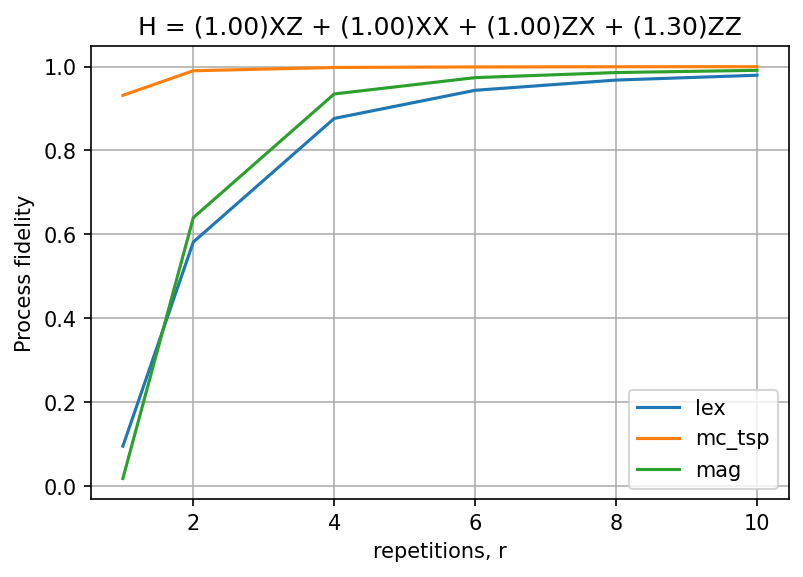

In [71]:
plot(r_vals, fidelities, labels, H)

In [43]:
h0 = get_exact_unitary([(1, 'XZ'), (1, 'XX'), (1, 'ZX'), (1, 'ZZ')])

In [44]:
h1 = get_pauli_sum_op([(1, 'XX'), (1, 'ZZ')]).exp_i()
h2 = get_pauli_sum_op([(1, 'XZ'), (1, 'ZX')]).exp_i()
u1 = h1.compose(h2).to_matrix()

In [47]:
d.processFidelity(h0, u1)

1.0

In [48]:
h0 - u1

array([[-1.11022302e-16+5.55111512e-17j, -1.66533454e-16+0.00000000e+00j,
         0.00000000e+00-5.55111512e-17j, -1.94289029e-16-5.55111512e-17j],
       [ 5.55111512e-17+0.00000000e+00j,  0.00000000e+00+5.55111512e-17j,
         8.32667268e-17+5.55111512e-17j, -5.55111512e-17+0.00000000e+00j],
       [ 0.00000000e+00-1.11022302e-16j,  1.11022302e-16+0.00000000e+00j,
        -2.22044605e-16+1.66533454e-16j,  1.11022302e-16+1.11022302e-16j],
       [-8.32667268e-17-1.11022302e-16j, -1.38777878e-16+1.11022302e-16j,
         0.00000000e+00+0.00000000e+00j, -1.11022302e-16-1.11022302e-16j]])

In [72]:
H = [(0.1, 'XZZ'), (1.2, 'XXZ'), (0.51, 'YZX'), (1.1, 'ZZZ'), (2.0, 'YYY')]
r_vals = [1, 2, 4, 6, 8, 10]
labels = ['lex', 'mc_tsp', 'mag']
fidelities = []
for label in labels:
    fidelities.append(fidelity_over_r(H, label, r_vals))

Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-7.28748034e-08 -7.28748033e-08 -4.75558202e-08 -4.75558201e-08
  1.04238453e-08  1.04238455e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.64454102e-08 -4.64454102e-08 -2.22522551e-08 -2.22522551e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.98786403e-08 -1.98786403e-08  1.87606469e-08  1.87606470e-08
  3.30968193e-08  3.30968193e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.00622989e-08 -5.00622987e-08 -3.68176263e-08 -3.68176261e-08
  2.22707147e-08  2.22707148e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-6.30244018e-08 -6.30244018e-08 -5.58757673e-08 -5.58757672e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.29071067e-08 -2.29071066e-08 -1.58375310e-08 -1.58375309e-08
  4.86763102e-08  4.86763102e-08  5.53034645e-08  5.53034645e-08]
Input channel is not TP. Tr_2[Choi] - I has 

lex: [0.0466, 0.5421, 0.8755, 0.9436, 0.9681, 0.9795]
mc_tsp: [0.1049, 0.879, 0.981, 0.9923, 0.9958, 0.9974]
mag: [0.0637, 0.8353, 0.9733, 0.9892, 0.9941, 0.9963]


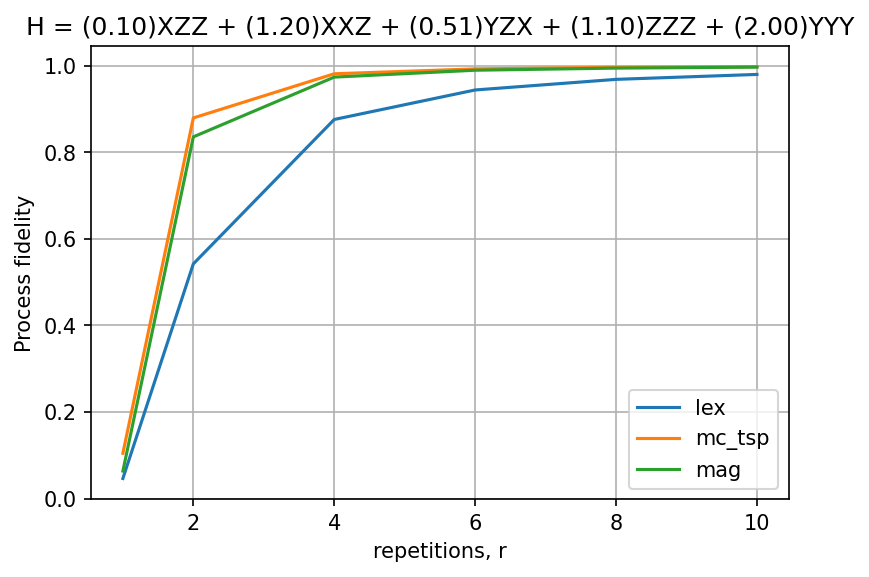

In [73]:
plot(r_vals, fidelities, labels, H)

In [115]:
hams = glob.glob('dqs/hamiltonians/*AS3.txt')
for h in hams:
    print(h)
    nq, H = dqs.hamiltonians.parseHfile(h)
    for term in H:
        print(term[1], end=' ')
    print()

dqs/hamiltonians/HydrogenPeroxide_sto-3g_JW_NIST_AS3.txt
IIYYXX YYIIXX IIXYYX XYIIYX XZXXZX YZYXZX IXZZZX ZXZZZX IXIZZX IXZIZX IXZZIX IIYXXY YXIIXY IIXXYY XXIIYY XZXYZY YZYYZY IYZZZY ZYZZZY IYIZZY IYZIZY IYZZIY IIIIIZ XZZZXZ YZZZYZ IIIIZZ IIIZIZ IIZIIZ IZIIIZ ZIIIIZ IYYXXI IXYYXI XZZZXI XIZZXI XZIZXI XZZIXI IYXXYI IXXYYI YZZZYI YIZZYI YZIZYI YZZIYI IIIIZI IIIZZI IIZIZI IZIIZI ZIIIZI YYXXII XYYXII YXXYII XXYYII IIIZII IIZZII IZIZII ZIIZII IIZIII IZZIII ZIZIII IZIIII ZZIIII ZIIIII 
dqs/hamiltonians/Ethanol_sto-3g_BK_NIST_AS3.txt
IIIXXX YIYXXX IIZXXX XYYZXX YXYIXX XYYIXX IIIYYX XZXYYX IZIYYX ZZIYYX XYXZYX XXYIYX IIIXZX IIZXZX IIIYXY YIYYXY IIZYXY XXYZXY XXYIXY YYYIXY IIIXYY XZXXYY IZIXYY ZZIXYY XXXZYY XYYIYY IIIYZY IIZYZY IIIIIZ IIIZXZ YIYZXZ IIZZXZ YZYIXZ YIYIXZ IIZIXZ IZZIXZ ZZZIXZ XYXXYZ XXXYYZ YIXZYZ XZYIYZ IIIIZZ XYYXZZ XXYYZZ IIIZZZ YIYZZZ IIZZZZ XZXIZZ IZIIZZ ZZIIZZ XYYXIZ XXYYIZ IIIZIZ YIYZIZ IIZZIZ XZXIIZ IZIIIZ ZZIIIZ IIIIXI IIIZXI XZXZXI IZIZXI ZZIZXI YIYIXI IIZIXI XXYXYI XYYYY

In [117]:
molecule = 'HydrogenPeroxide_sto-3g_JW_NIST_AS2'
_, H = dqs.hamiltonians.parseHfile(f'dqs/hamiltonians/{molecule}.txt')
r_vals = [1, 2, 4, 6, 8, 10]
labels = ['lex', 'mc_tsp', 'mag']
fidelities = []
for label in labels:
    fidelities.append(fidelity_over_r(H, label, r_vals))

Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.46702469e-08 -4.16462739e-08 -4.16462736e-08 -3.45332437e-08
 -1.45156207e-08  1.64363266e-08  2.46930869e-08  2.46930870e-08
  2.66833506e-08  4.46386940e-08  5.03750676e-08  5.03750678e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.16462739e-08 -4.16462736e-08 -2.49496618e-08 -1.45156207e-08
  1.42752883e-08  2.46930868e-08  2.46930870e-08  2.66833506e-08
  3.72907104e-08  5.03750675e-08  5.03750678e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.16462739e-08 -4.16462736e-08 -3.84124117e-08 -1.45156207e-08
  2.46930867e-08  2.46930871e-08  2.66833506e-08  2.76350437e-08
  3.37121138e-08  3.93476295e-08  5.03750675e-08  5.03750678e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-7.05684437e-08 -4.16462738e-08 -4.16462737e-08 -2.72489496e-08
 -1.78602677e-08 -1.45156207e-08  2.46930868e-08  2.46930870e-08
  2.66833506e-08  3.15998978e-08  

lex: [0.717, 0.915, 0.4123, 0.4744, 0.6136, 0.7181]
mc_tsp: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
mag: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


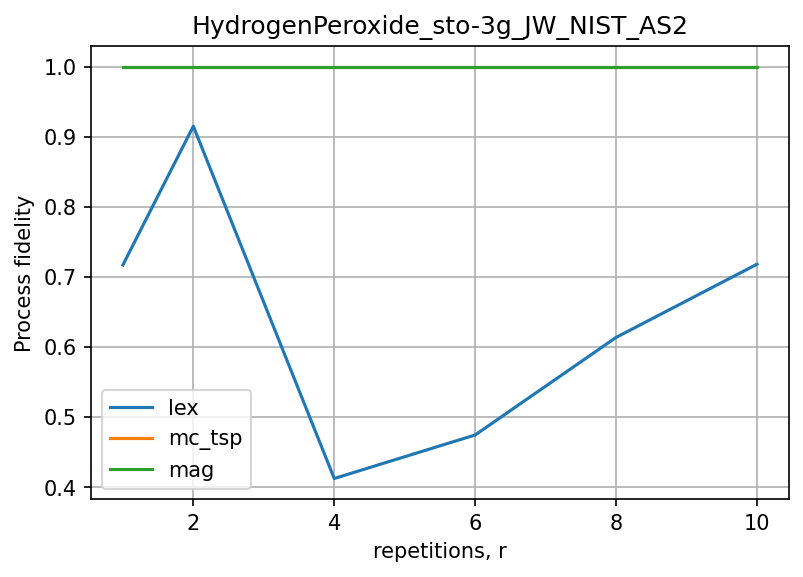

In [118]:
plot(r_vals, fidelities, labels, H, title=molecule)

In [180]:
nq = 5
nt = 14
H = dqs.hamiltonians.random_H(nq, nt)
r_vals = [1, 2, 4, 6, 8, 10]
labels = ['lex', 'mc_tsp', 'mag', 'rand']
fidelities = []
for label in labels:
    fidelities.append(fidelity_over_r(H, label, r_vals))

Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-6.89808008e-08 -6.02726790e-08 -5.63764405e-08 -5.05204829e-08
 -4.42973060e-08 -3.85942964e-08 -3.54808922e-08 -3.25446173e-08
 -2.67263268e-08 -2.57742793e-08 -2.11520190e-08 -1.69367838e-08
 -1.42922688e-08 -1.05222819e-08  1.34098100e-08  1.69790912e-08
  2.26687513e-08  2.57845743e-08  2.85484081e-08  3.05663668e-08
  3.56056433e-08  4.23428462e-08  4.75883573e-08  5.68470570e-08
  5.81348238e-08  6.65924199e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-6.23957964e-08 -5.61159104e-08 -5.04650172e-08 -4.64838383e-08
 -3.95107259e-08 -3.60395545e-08 -3.17121999e-08 -2.71143108e-08
 -2.42011645e-08 -1.98168540e-08 -1.60041261e-08 -1.41664388e-08
  1.17021877e-08  1.61584734e-08  2.41656368e-08  2.83355967e-08
  3.03899508e-08  3.31217644e-08  3.75357860e-08  4.51327377e-08
  4.99060208e-08  5.24726098e-08  5.67074552e-08  6.04064766e-08
  6.87364643e-08]
Input channel is not TP. Tr_2[Choi] 

lex: [0.0016, 0.1015, 0.6671, 0.8417, 0.9086, 0.9408]
mc_tsp: [0.0036, 0.2569, 0.8081, 0.918, 0.9544, 0.971]
mag: [0.0007, 0.1736, 0.7397, 0.8816, 0.9327, 0.9567]
rand: [0.0015, 0.1218, 0.6718, 0.8422, 0.9085, 0.9405]


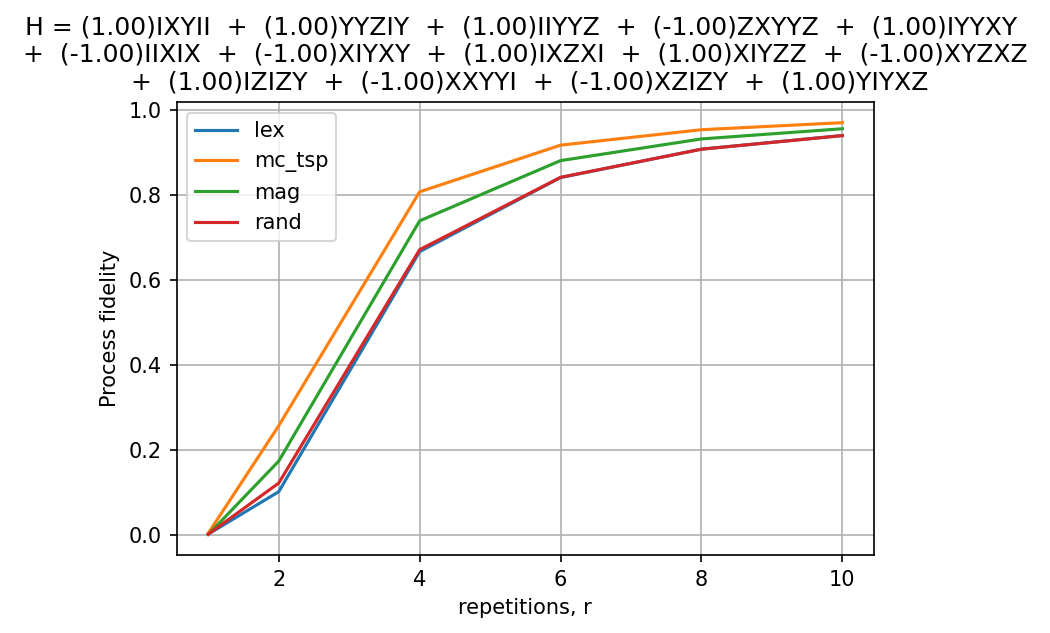

In [181]:
plot(r_vals, fidelities, labels, H)

# Energy and Reaction Rates

In [5]:
def get_exact_unitary(H, t):
    pauli_sum_op = PauliSumOp.from_list(H, coeff=t)
    return pauli_sum_op.exp_i().to_matrix()

def time_simulation(Hfunc, init_state, meas_op, tstart=0, tend=4, tstep=0.01):
    expectations = []
    time = np.arange(tstart, tend, tstep)
    for t in time:
        evolution_unitary = PauliSumOp.from_list(Hfunc(t), coeff=t)
        final_state = init_state.evolve(evolution_unitary.exp_i())
        expectations.append(final_state.expectation_value(meas_op).real)
    return expectations, time

def trotter_time_simulation(dqs_obj, Hfunc, init_state, meas_op, tstart=0, tend=4, tstep=0.01, r=1):
    expectations = []
    process_fidelity = []
    time = np.arange(tstart, tend, tstep)
    for t in time:
        curH = Hfunc(t)
        dqs_obj.update_coefficients([(term[1], term[0]) for term in curH])
        dqs_obj.gen_circuit(t=t, r=r)
        evolution_unitary = dqs_obj.getCircuitUnitary()
        final_state = init_state.evolve(evolution_unitary)
        expectations.append(final_state.expectation_value(meas_op).real)
        
        exact_unitary = get_exact_unitary(curH, t)
        process_fidelity.append(dqs_obj.processFidelity(exact_unitary, evolution_unitary))
    return expectations, time, process_fidelity

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


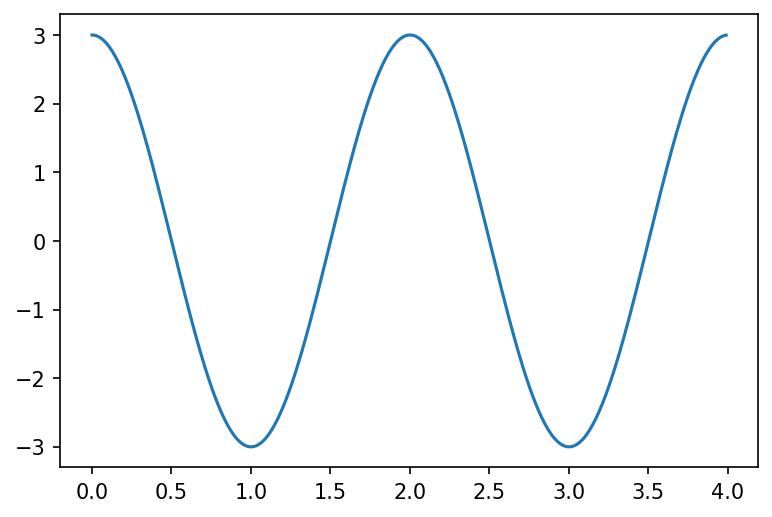

In [102]:
nq = 3
gamma = 3.14 / 2
H = [('IIX', gamma), ('IXI', gamma), ('XII', gamma)]
#H = [('X', gamma)]

init_state = qiskit.quantum_info.Statevector.from_int(0, int(2**nq))
print(init_state)

meas_op = get_pauli_sum_op([(1.0, 'IIZ'), (1.0, 'IZI'), (1.0, 'ZII')])
#meas_op = get_pauli_sum_op([(1.0, 'Z')])

expectations, time = time_simulation(H, init_state, meas_op)

fig, ax = plt.subplots(dpi=150)

ax.plot(time, expectations)

               
q_0: ──■───────
     ┌─┴─┐     
q_1: ┤ X ├──■──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘
3.0


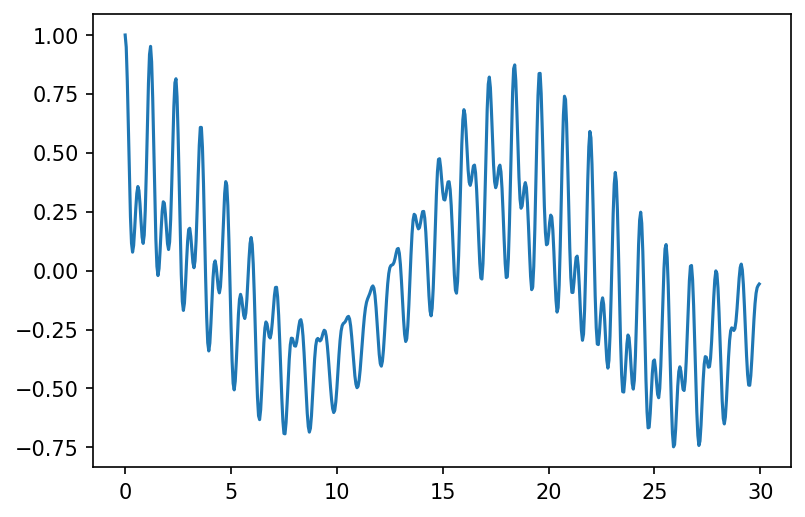

In [129]:
nq = 3
mu = -5
interaction = -1
H = [('IZZ', interaction), ('ZZI', interaction), ('ZIZ', interaction), ('IIX', 0.2), ('XII', 0.5*mu), ('IXI', 1.0*mu)]

init_circ = qiskit.QuantumCircuit(nq)
init_circ.cx(0,1)
init_circ.cx(1,2)
init_state = qiskit.quantum_info.Statevector.from_instruction(init_circ)
print(init_circ)

meas_op = PauliSumOp.from_list([('ZII', gamma), ('IZI', gamma), ('IIZ', gamma)])

print(init_state.expectation_value(meas_op).real)

expectations, time = time_simulation(H, init_state, meas_op, tend=30, tstep=0.05)
fig, ax = plt.subplots(dpi=150)
ax.plot(time, [expval / nq for expval in expectations])

[('YYXX', -0.5270026512078708), ('XYYX', 0.5270026512078708), ('YXXY', 0.5270026512078708), ('XXYY', -0.5270026512078708), ('IIIZ', 6.982922762997513), ('IIZZ', 0.6596700942103038), ('IZIZ', 0.1323827348627502), ('ZIIZ', 0.659385386070621), ('IIZI', 6.9829227629975135), ('IZZI', 0.659385386070621), ('ZIZI', 0.1323827348627502), ('IZII', 6.983973664851903), ('ZZII', 0.6591013784303086), ('ZIII', 6.983973664851903)]
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     


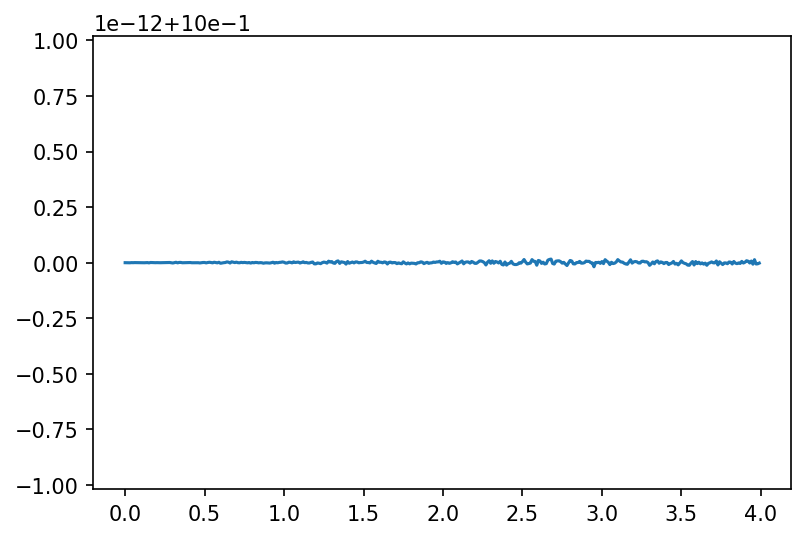

In [133]:
molecule = 'HydrogenPeroxide_sto-3g_JW_NIST_AS2'
nq = 4
_, H = dqs.hamiltonians.parseHfile(f'dqs/hamiltonians/{molecule}.txt')
H = [(term[1], term[0]) for term in H]
print(H)

init_circ = qiskit.QuantumCircuit(nq)
#init_circ.x([3])
print(init_circ)
init_state = qiskit.quantum_info.Statevector.from_instruction(init_circ)
meas_op = PauliSumOp.from_list([('IIIZ', 1), ('IIZI', 1), ('IZII', 1), ('ZIII', 1)])

expectations, time = time_simulation(H, init_state, meas_op)
fig, ax = plt.subplots(dpi=150)
ax.plot(time, [expval / nq for expval in expectations])

# Trotterization approximations to Ising Model

In [6]:
nq = 3

def hamiltonian(t):
    omega = np.pi
    epsilon = -1
    interaction = -1
    factor = epsilon * np.cos(omega * t)
    return [('IZZ', interaction), ('ZZI', interaction), ('ZIZ', interaction), ('IIX', factor), ('XII', factor), ('IXI', factor)]

init_circ = qiskit.QuantumCircuit(nq)
#init_circ.x(1)
#init_circ.cx(1,2)
init_state = qiskit.quantum_info.Statevector.from_instruction(init_circ)
print(init_circ)

meas_op = PauliSumOp.from_list([('ZII', 1), ('IZI', 1), ('IIZ', 1)])

print('Exact results...')
exact_expectations, times = time_simulation(hamiltonian, init_state, meas_op, tend=0.5*np.pi, tstep=0.01)

results = [('Exact', exact_expectations, times, [])]
for sort_type in ['lex', 'mag', 'mc_tsp', 'rand']:
    print(f'{sort_type.upper()} results...')
    dqs_obj = dqs.quantum_dynamics.Dynamics([(term[1], term[0]) for term in hamiltonian(1)])
    dqs_obj.sort_hamiltonian(sort_type)
    expectations, time, process_fidelity = trotter_time_simulation(dqs_obj, hamiltonian, init_state, meas_op, tend=0.5*np.pi, tstep=0.01)
    results.append((sort_type.upper(), expectations, time, process_fidelity))
print('done')

     
q_0: 
     
q_1: 
     
q_2: 
     
Exact results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.80145962e-08 -3.80145962e-08 -3.80105151e-08 -3.80105151e-08
 -3.79840395e-08 -3.79760454e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.31678497e-08 -4.31678497e-08 -4.31515860e-08 -4.31515860e-08
 -4.30176089e-08 -4.29842716e-08  2.43392020e-08  2.43395384e-08]


LEX results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.31927991e-08 -3.26774704e-08 -3.21821525e-08 -3.21821525e-08
 -3.18090913e-08 -3.18090913e-08 -2.94403100e-08 -2.92156253e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.71373728e-08 -5.71318092e-08  2.77314956e-08  2.77314957e-08
  2.78082255e-08  2.78082256e-08  2.86690527e-08  2.88316829e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [4.68272745e-08 4.68573991e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.55194719e-08 -2.49319080e-08 -2.49319080e-08 -2.47340782e-08
 -2.45629593e-08 -2.45629592e-08  2.01229777e-08  2.01293509e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.37607610e-08 -2.96807845e-08 -2.96807844e-08 -2.96076255e-08
 -2.75577046e-08 -2.75577046e-08  2.12632167e-08  2.13830018e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.05485497e-08  4.57693863e-08  4.58491359e-08

MAG results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.31927991e-08 -3.26774704e-08 -3.21821524e-08 -3.21821524e-08
 -3.18090912e-08 -3.18090912e-08 -2.94403101e-08 -2.92156253e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.71373726e-08 -5.71318090e-08  2.77314956e-08  2.77314957e-08
  2.78082255e-08  2.78082256e-08  2.86690527e-08  2.88316829e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [4.68272744e-08 4.68573990e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.55194719e-08 -2.49319080e-08 -2.49319080e-08 -2.47340782e-08
 -2.45629592e-08 -2.45629592e-08  2.01229778e-08  2.01293509e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.37607610e-08 -2.96807845e-08 -2.96807844e-08 -2.96076254e-08
 -2.75577046e-08 -2.75577046e-08  2.12632167e-08  2.13830018e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.05485498e-08  4.57693865e-08  4.58491360e-08

MC_TSP results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.80145962e-08 -3.80145962e-08 -3.80105151e-08 -3.80105151e-08
 -3.79840395e-08 -3.79760454e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.31678498e-08 -4.31678498e-08 -4.31515861e-08 -4.31515860e-08
 -4.30176089e-08 -4.29842716e-08  2.43392021e-08  2.43395385e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.31927991e-08 -3.26774704e-08 -3.21821524e-08 -3.21821524e-08
 -3.18090912e-08 -3.18090912e-08 -2.94403101e-08 -2.92156253e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.71373726e-08 -5.71318090e-08  2.77314956e-08  2.77314957e-08
  2.78082255e-08  2.78082256e-08  2.86690527e-08  2.88316829e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [4.68272744e-08 4.68573990e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.55194719e-08 -2.49319080e-08 -2.49319080e-08 -2.47340782e-08
 -2.45629592e-0

RAND results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.33090463e-08 -3.32139656e-08 -3.21821524e-08 -3.18090912e-08
 -3.17965647e-08 -3.11616808e-08 -2.96018647e-08 -2.94343265e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.71369832e-08 -5.71364561e-08  2.77314957e-08  2.78082256e-08
  2.79845048e-08  2.80541953e-08  2.84304659e-08  2.85755484e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [4.68334594e-08 4.68508790e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.53614759e-08 -2.52627799e-08 -2.49319080e-08 -2.46963182e-08
 -2.45629592e-08 -2.44260823e-08  2.01182713e-08  2.01322965e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.22697863e-08 -3.14496236e-08 -2.96807845e-08 -2.91095528e-08
 -2.78551032e-08 -2.75577046e-08  2.13598823e-08  2.13635270e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.01233586e-08  4.57035497e-08  4.59408970e-08

done


Text(0.5, 0, 'Time')

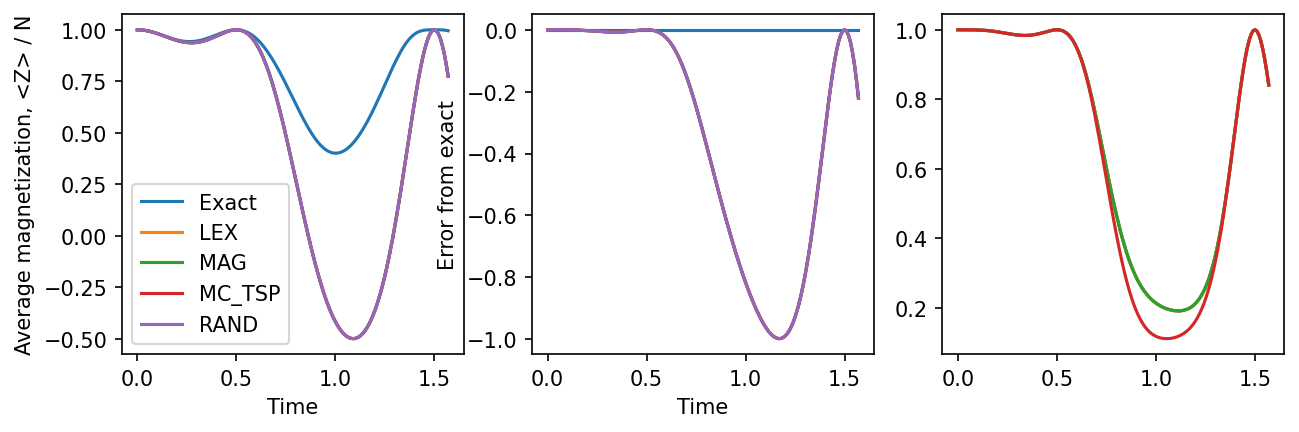

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, dpi=150, figsize=[10,3])
exact_results = results[0][1]
for i, (label, expectations, time, pfids) in enumerate(results):
    offset = 0.01 * i * 0
    ax[0].plot(time, [expval / nq + offset for expval in expectations], label=label)
    ax[1].plot(time, [(approx - exact)/ nq for approx, exact in zip(expectations, exact_results)], label=label)
    if len(pfids) == len(time):
        ax[2].plot(time, pfids, label=label)
ax[0].legend()
ax[0].set_ylabel('Average magnetization, <Z> / N')
ax[0].set_xlabel('Time')
ax[1].set_ylabel('Error from exact')
ax[1].set_xlabel('Time')

In [44]:
nq = 4

random_hamiltonian = dqs.hamiltonians.random_H(nq, 20, binary=False)
print(random_hamiltonian)

def hamiltonian(t):
    return [(term[1], term[0]) for term in random_hamiltonian]

init_circ = qiskit.QuantumCircuit(nq)
#init_circ.x(1)
#init_circ.cx(1,2)
init_state = qiskit.quantum_info.Statevector.from_instruction(init_circ)
print(init_circ)

meas_op = PauliSumOp.from_list([('ZIII', 1), ('IZII', 1), ('IIZI', 1), ('IIIZ', 1)])

print('Exact results...')
exact_expectations, times = time_simulation(hamiltonian, init_state, meas_op, tend=0.5, tstep=0.01)

results = [('Exact', exact_expectations, times, [])]
for sort_type in ['lex', 'mag', 'mc_tsp', 'rand']:
    print(f'{sort_type.upper()} results...')
    dqs_obj = dqs.quantum_dynamics.Dynamics([(term[1], term[0]) for term in hamiltonian(1)])
    dqs_obj.sort_hamiltonian(sort_type)
    simresult = trotter_time_simulation(dqs_obj, hamiltonian, init_state, meas_op, tend=0.5, tstep=0.01)
    results.append((sort_type.upper(), *simresult))
print('done')

[(-0.7336992409213335, 'IXZX'), (0.3217849823054739, 'XXZI'), (0.2062743971551923, 'XXXX'), (-0.1498678439803092, 'XZXY'), (0.8653598715330519, 'XZYI'), (0.8060276468339131, 'YYYY'), (-0.21545311683833268, 'IZZX'), (-0.7482382723717598, 'YYZY'), (-0.6368607068788816, 'ZZYI'), (0.6652800937090209, 'IZIZ'), (-0.3273461213168155, 'XXZZ'), (0.8169165234478731, 'IXXX'), (-0.6791878637660345, 'YXXX'), (0.9248511741977102, 'YXXI'), (-0.22228910002887659, 'YYXZ'), (-0.7005380097549893, 'XXII'), (-0.7352023245467374, 'ZYXX'), (-0.5959758808707021, 'YZXZ'), (-0.5194218317267281, 'IIZY'), (-0.9635204380154767, 'YZZI')]
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
Exact results...
LEX results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.89972273e-08 -5.80868064e-08 -5.50712296e-08 -5.06674308e-08
 -3.69399557e-08 -3.08289323e-08 -2.42824039e-08 -1.70466019e-08
  2.89017989e-08  3.32037928e-08  5.07148639e-08  5.47734499e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.08639203e-08 -3.95363813e-08 -3.34076360e-08 -3.17292962e-08
 -2.95422549e-08 -2.16496135e-08 -1.82266612e-08 -1.17218912e-08
 -1.10438144e-08  1.40839047e-08  1.44526179e-08  2.62223482e-08
  2.84742272e-08  4.92148923e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.83291805e-08 -5.23365344e-08 -5.00165208e-08 -4.66887164e-08
 -4.62041688e-08 -3.08361998e-08 -2.54519872e-08 -1.72628964e-08
 -1.08751307e-08  1.04495573e-08  3.09911718e-08  3.91441755e-08
  5.69391624e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.97549064e-08 -5.82836374e-08 -5.54252609e-08 -3.05497058e-08
 -3.04067203e-08 -2.81679353e-08 

MAG results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.88725765e-08 -5.60710649e-08 -5.52420424e-08 -5.07567137e-08
 -4.82751265e-08 -4.75470896e-08 -2.61505390e-08 -1.81679616e-08
  2.36585907e-08  2.42813218e-08  2.47641110e-08  2.64435854e-08
  3.33663979e-08  4.83900054e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.98595835e-08 -4.77939582e-08 -4.75319608e-08 -3.52007362e-08
 -3.12463882e-08 -3.08593721e-08  1.59098892e-08  2.42431989e-08
  2.48686468e-08  4.37046337e-08  4.53652609e-08  5.03575227e-08
  5.07483470e-08  5.26631369e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.61165285e-08 -5.46905262e-08 -5.29039687e-08 -5.10522274e-08
 -4.21658421e-08 -2.55752132e-08 -1.16538127e-08  2.26509394e-08
  2.55089985e-08  3.00271202e-08  4.02184175e-08  4.11938479e-08
  4.53804302e-08  4.97402534e-08  5.20484859e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.44745348e-08 -5.23318024e-08 

MC_TSP results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.77442542e-08 -5.35354647e-08 -5.12126034e-08 -5.08441461e-08
 -4.39167616e-08 -3.87420004e-08 -3.13340514e-08 -1.72109123e-08
 -1.09575386e-08 -1.02523783e-08  1.14082897e-08  1.25999578e-08
  2.74399501e-08  3.22830207e-08  3.47074485e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.92989263e-08 -4.90225123e-08 -4.64115197e-08 -4.11797446e-08
 -3.94965212e-08 -1.63360764e-08  1.94603768e-08  2.08434757e-08
  3.23197900e-08  3.55606507e-08  4.54686799e-08  5.28350564e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.64202264e-08 -5.16358269e-08 -3.99816348e-08 -1.77964559e-08
  1.80004279e-08  2.67539716e-08  3.04946189e-08  3.46336777e-08
  3.98132673e-08  4.06674262e-08  4.69363730e-08  4.94502165e-08
  5.11390963e-08  5.40439401e-08  5.57708721e-08  5.75867109e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.89537834e-08 -5.63811985e-08 -

RAND results...


Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.72263946e-08 -5.05624835e-08 -5.01545279e-08 -3.94893910e-08
 -3.67235041e-08 -1.17711341e-08 -1.09064919e-08 -1.01435489e-08
  2.76864011e-08  3.03070853e-08  3.12575988e-08  3.33918603e-08
  3.99625023e-08  4.99153327e-08  5.15798331e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.70898075e-08 -4.44324745e-08 -2.35719809e-08 -1.69788615e-08
  1.05954266e-08  1.28884060e-08  1.57749607e-08  1.83824136e-08
  3.87510086e-08  4.03503905e-08  5.12975162e-08  5.64217385e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.63131816e-08 -4.49619569e-08 -4.37634034e-08 -3.95198892e-08
 -1.75209135e-08 -1.01227629e-08  3.54133679e-08  3.78044261e-08
  4.29510788e-08  4.53472175e-08  4.94492899e-08  5.44243823e-08]
Input channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-5.78676728e-08 -4.46341345e-08 -3.76856248e-08 -3.29115248e-08
 -3.06666325e-08 -2.17538338e-08 -

done


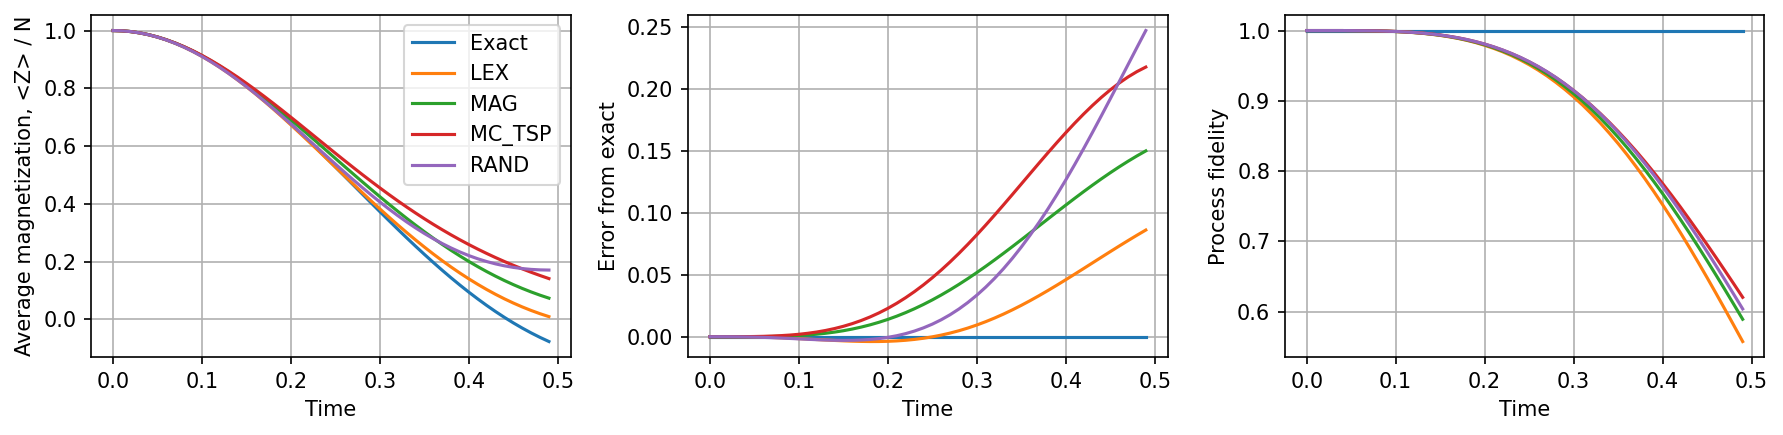

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, dpi=150, figsize=[12,3])
exact_results = results[0][1]
for i, (label, expectations, time, pfids) in enumerate(results):
    offset = 0.01 * i * 0
    ax[0].plot(time, [expval / nq + offset for expval in expectations], label=label)
    ax[1].plot(time, [(approx - exact)/ nq for approx, exact in zip(expectations, exact_results)], label=label)
    if label == 'Exact':
        pfids = [1]*len(time)
    ax[2].plot(time, pfids, label=label)
ax[0].legend()
ax[0].set_ylabel('Average magnetization, <Z> / N')
ax[1].set_ylabel('Error from exact')
ax[2].set_ylabel('Process fidelity')
for axis in ax:
    axis.grid()
    axis.set_xlabel('Time')
plt.tight_layout()

In [2]:
def get_exact_unitary(H, t):
    if isinstance(H[0][0], float):
        H = [(term[1], term[0]) for term in H]
    pauli_sum_op = PauliSumOp.from_list(H, coeff=t)
    return pauli_sum_op.exp_i().to_matrix()

In [7]:
t = 1
H = [(1.0, 'ZZZ'), (2.6, 'ZIZ')]
hamsim = dqs.quantum_dynamics.Dynamics(H)
Uexact = get_exact_unitary(H, t)
#hamsim.sort_hamiltonian('lex')
hamsim.gen_circuit(t, r=1)
Uapprox = hamsim.getCircuitUnitary()

In [8]:
hamsim.diamondNorm(Uexact, Uapprox)

0.0

In [11]:
hamsim.gen_circuit(t, r=2).draw(fold=-1)

░                       ░                               ░                       ░ 
q26_0: ──■───────────────────────■───░───■───────────────■───░───■───────────────────────■───░───■───────────────■───░─
         │                       │   ░   │               │   ░   │                       │   ░   │               │   ░ 
q26_1: ──┼────■─────────────■────┼───░───┼───────────────┼───░───┼────■─────────────■────┼───░───┼───────────────┼───░─
       ┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐ ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░ ┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐ ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░ 
q26_2: ┤ X ├┤ X ├┤ Rz(1) ├┤ X ├┤ X ├─░─┤ X ├┤ Rz(2.6) ├┤ X ├─░─┤ X ├┤ X ├┤ Rz(1) ├┤ X ├┤ X ├─░─┤ X ├┤ Rz(2.6) ├┤ X ├─░─
       └───┘└───┘└───────┘└───┘└───┘ ░ └───┘└─────────┘└───┘ ░ └───┘└───┘└───────┘└───┘└───┘ ░ └───┘└─────────┘└───┘ ░

In [12]:
hamsim.total_cnot_count(r=2)

8